**Dataset Download**

In [ ]:
import kagglehub

# Download datasets
path_ischemia = kagglehub.dataset_download("bjoernjostein/ischemia-dataset")
path_normal = kagglehub.dataset_download("bjoernjostein/normalsinusdataset")

print(f"Path to Ischemia dataset files: {path_ischemia}")
print(f"Path to Normal Sinus dataset files: {path_normal}")

100%|██████████| 174M/174M [00:03<00:00, 49.9MB/s]

Extracting files...


100%|██████████| 1.00G/1.00G [00:17<00:00, 60.9MB/s]

Extracting files...


Path to Ischemia dataset files: /root/.cache/kagglehub/datasets/bjoernjostein/ischemia-dataset/versions/1
Path to Normal Sinus dataset files: /root/.cache/kagglehub/datasets/bjoernjostein/normalsinusdataset/versions/3


In [ ]:
# Install necessary libraries
!pip install ecg_plot
!pip install wfdb
!pip install neurokit2
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 17.3 MB/s eta 0:00:00


**Model Implementation**

In [ ]:
import ecg_plot
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk  # neurokit2 for ECG processing
from scipy import signal
from scipy.io import loadmat
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import cv2
from matplotlib.collections import LineCollection
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from scipy import signal
from scipy.fft import fft
import plotly.graph_objects as go

In [ ]:
#Load .mat files and pad ECG signals to a uniform length
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

# Load Normal Sinus dataset
normal_sinus = []
directory = "/root/.cache/kagglehub/datasets/bjoernjostein/normalsinusdataset/versions/3/only_sinus"

for ecgfilename in tqdm(sorted(os.listdir(directory))):
    filepath = directory + os.sep + ecgfilename
    if filepath.endswith(".mat"):
        data, header_data = load_challenge_data(filepath)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        normal_sinus.append(data)
normal_sinus = np.asarray(normal_sinus)

# Load Ischemia dataset
ischemia = []
directory = "/root/.cache/kagglehub/datasets/bjoernjostein/ischemia-dataset/versions/1/ischemia_dataset"
j = 0
for ecgfilename in tqdm(sorted(os.listdir(directory))):
    filepath = directory + os.sep + ecgfilename
    if filepath.endswith(".mat"):
        data, header_data = load_challenge_data(filepath)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ischemia.append(data)
ischemia = np.asarray(ischemia)

100%|██████████| 5118/5118 [00:03<00:00, 1386.82it/s]


In [ ]:
normal_sinus[1]

array([[-122, -116, -104, ...,  -48,  -48,  -50],
       [ -92,  -89,  -82, ...,  -42,  -42,  -44],
       [  30,   27,   22, ...,    6,    6,    6],
       ...,
       [-123, -109,  -84, ...,  -79,  -81,  -82],
       [-155, -155, -147, ...,  -83,  -85,  -87],
       [-132, -137, -133, ..., -102, -103, -105]], dtype=int32)

In [ ]:
# Use neurokit2 for ECG cleaning and R-peak detection

# Segment ECG signals into heartbeats and resample them
def resample_beats(beats):
    rsmp_beats = []
    for i in beats:
        i = np.asarray(i)

        # Check for NaN values and handle them
        if np.isnan(i).any():
            i = np.nan_to_num(i)

        # Check for empty signals after NaN removal
        if len(i) == 0:
            continue  # Skip this beat

        try:
            f = signal.resample(i, 250)
            rsmp_beats.append(f)
        except Exception as e:
            print(f"Error resampling signal: {e}")
            continue #skip this beat.
    if len(rsmp_beats) > 0:
      rsmp_beats = np.asarray(rsmp_beats)
      return rsmp_beats
    else:
      return np.array([])


# Calculate median beat for each lead
def median_beat(beat_dict):
    beats = []
    for i in beat_dict.values():
        beats.append(i['Signal'])
    beats = np.asarray(beats)

    rsmp_beats = resample_beats(beats)

    if rsmp_beats.size == 0:
        print("rsmp_beats is empty")
        return np.array([])

    if np.isnan(rsmp_beats).any():
        print("NaN values found in resampled beats!")
        return np.nan

    med_beat = np.median(rsmp_beats, axis=0)
    return med_beat


In [ ]:

def process_ecgs(raw_ecg):
    processed_ecgs=[]
    for i in tqdm(range(len(raw_ecg))):
        leadII = raw_ecg[i][1]
        leadII_clean = nk.ecg_clean(leadII, sampling_rate=500, method="neurokit")
        r_peaks = nk.ecg_findpeaks(leadII_clean, sampling_rate=500, method="neurokit", show=False)
        twelve_leads = []
        for j in raw_ecg[i]:
            try:
                beats = nk.ecg_segment(j, rpeaks=r_peaks['ECG_R_Peaks'], sampling_rate=500, show=False)
                med_beat = median_beat(beats)
                twelve_leads.append(med_beat)
            except:
                beats = np.ones(250)*np.nan
                twelve_leads.append(beats)
        processed_ecgs.append(twelve_leads)
    processed_ecgs = np.asarray(processed_ecgs)
    return processed_ecgs

norm_ecgs = process_ecgs(normal_sinus)
ischemia_ecgs = process_ecgs(ischemia)

100%|█████████▉| 15085/15090 [2:48:17<00:02,  1.97it/s]/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 65%|██████▍   | 1663/2559 [19:21<12:26,  1.20it/s]/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 87%|████████▋ | 2233/2559 [25:47<03:25,  1.58it/s]/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 97%|█████████▋| 2472/2559 [28:30<00:54,  1.59it/s]/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
100%|██████████| 2559/2559 [29:29<00:00,  1.45it/s]


In [ ]:
#The data is saved as pickle files for future use. This approach significantly \n
#reduces the time required for subsequent runs of the code, as it avoids repetitive data processing.
import joblib

if os.path.exists('normal_sinus.pkl'):
    normal_sinus = joblib.load('normal_sinus.pkl')
else:
    normal_sinus = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = os.path.join(directory, ecgfilename)
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences_torch(data, maxlen=5000, padding_value=0.0)
            normal_sinus.append(data)
    normal_sinus = torch.stack(normal_sinus)
    joblib.dump(normal_sinus, 'normal_sinus.pkl')

if os.path.exists('ischemia.pkl'):
    ischemia = joblib.load('ischemia.pkl')
else:
    ischemia = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = os.path.join(directory, ecgfilename)
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences_torch(data, maxlen=5000, padding_value=0.0)
            ischemia.append(data)
    ischemia = torch.stack(ischemia)
    joblib.dump(ischemia, 'ischemia.pkl')

100%|██████████| 5118/5118 [00:02<00:00, 1845.31it/s]


In [ ]:
#Retrieve the saved data
import joblib

# Load previously processed datasets
normal = joblib.load('normal_sinus.pkl')
ischemia = joblib.load('ischemia.pkl')


In [ ]:
# Replace NaN values with ones.
def remove_nans(ecg_arr):
    new_arr = []
    for i in tqdm(ecg_arr):
        twelve_lead = []
        for j in i:
            if j[0] != j[0]:
                j = np.ones(250)
            twelve_lead.append(j)
        new_arr.append(twelve_lead)
    new_arr = np.asarray(new_arr)
    return new_arr

new_norm = remove_nans(norm_ecgs)
new_ischemia = remove_nans(ischemia_ecgs)

100%|██████████| 2559/2559 [00:00<00:00, 47140.47it/s]


In [ ]:
new_norm[0]
new_ischemia[0]

array([[-42.09621877, -42.18459784, -55.50098795, ..., -36.29135744,
        -39.39173205, -40.51115131],
       [  5.82838608,   6.32385756,  16.30565172, ..., -13.30026464,
         -4.40595932,   1.98057827],
       [ 47.44882988,  53.98896982,  54.85429699, ...,  34.90220607,
         43.74856325,  57.18148028],
       ...,
       [-14.95004204,  -1.70597079,   0.        , ..., -21.74499735,
        -14.0367993 ,  -3.07227677],
       [-45.84278961, -33.9932368 , -29.03861434, ..., -56.20096265,
        -45.75617551, -54.10298868],
       [-44.55375005, -33.40752572, -35.66478867, ..., -61.65887221,
        -69.90527024, -63.56268309]])

In [ ]:
clean_ischemia = new_ischemia
clean_norm = new_norm
print(f"Patients with Normal Sinus Rythm = {clean_norm.shape[0]}")
print(f"Patients with Ischemia = {clean_ischemia.shape[0]}")

Patients with Normal Sinus Rythm = 15090
Patients with Ischemia = 2559


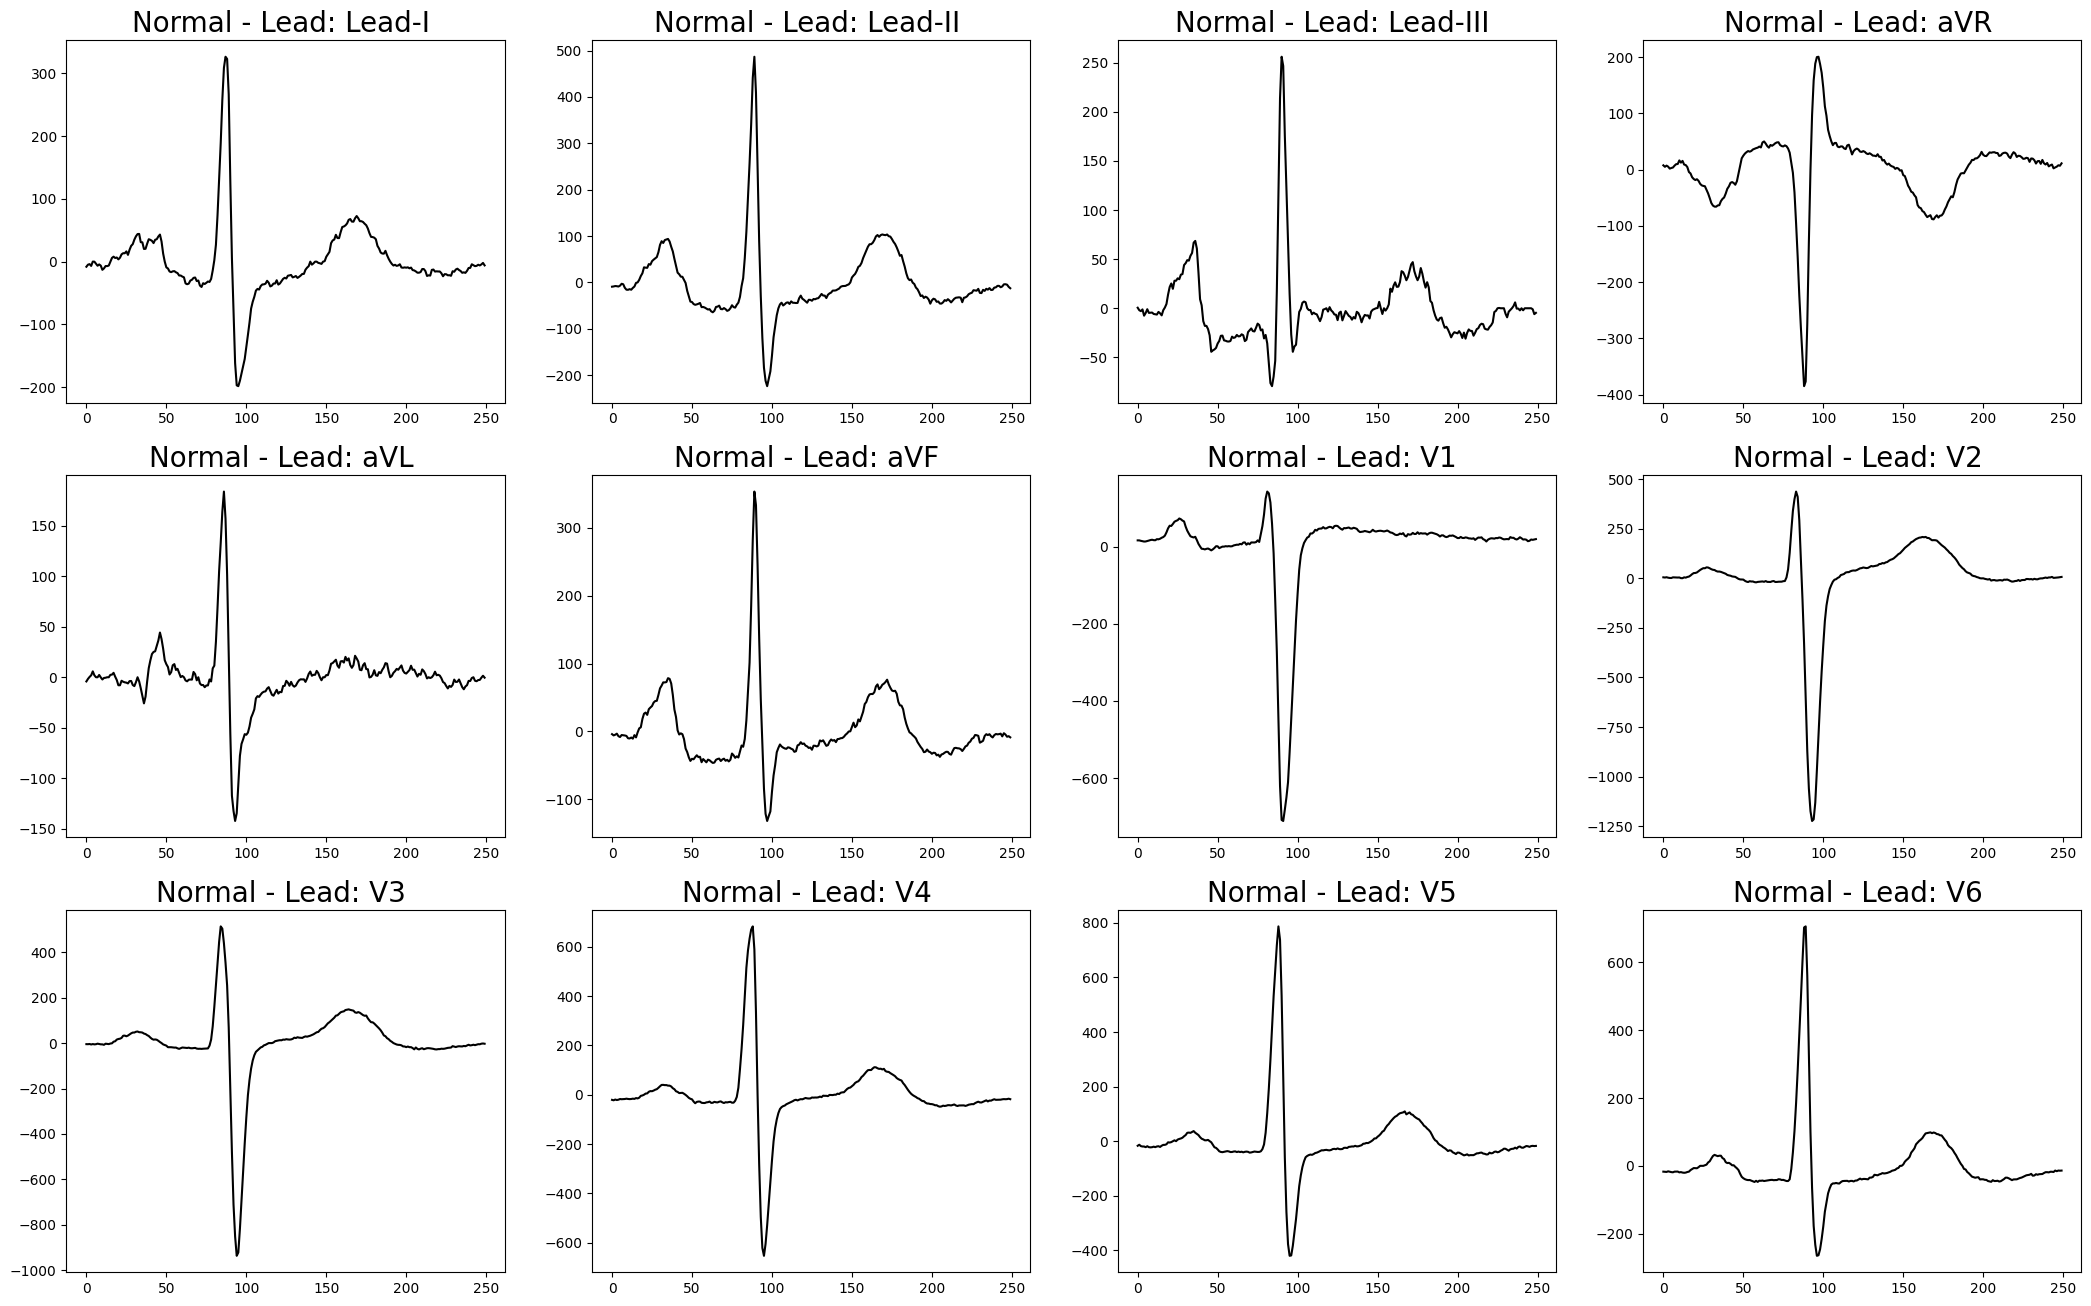

In [ ]:
# Visualizing ECG Leads: Normal Sinus Example
leads = ["Lead-I","Lead-II", "Lead-III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
plt.figure(figsize=(26, 16))
for l in range(12):
    plt.subplot(3, 4, l + 1)
    plt.title("Normal - Lead: {} ".format(leads[l]), fontsize=20)
    plt.plot(clean_norm[0].reshape(12,250)[l],'k')

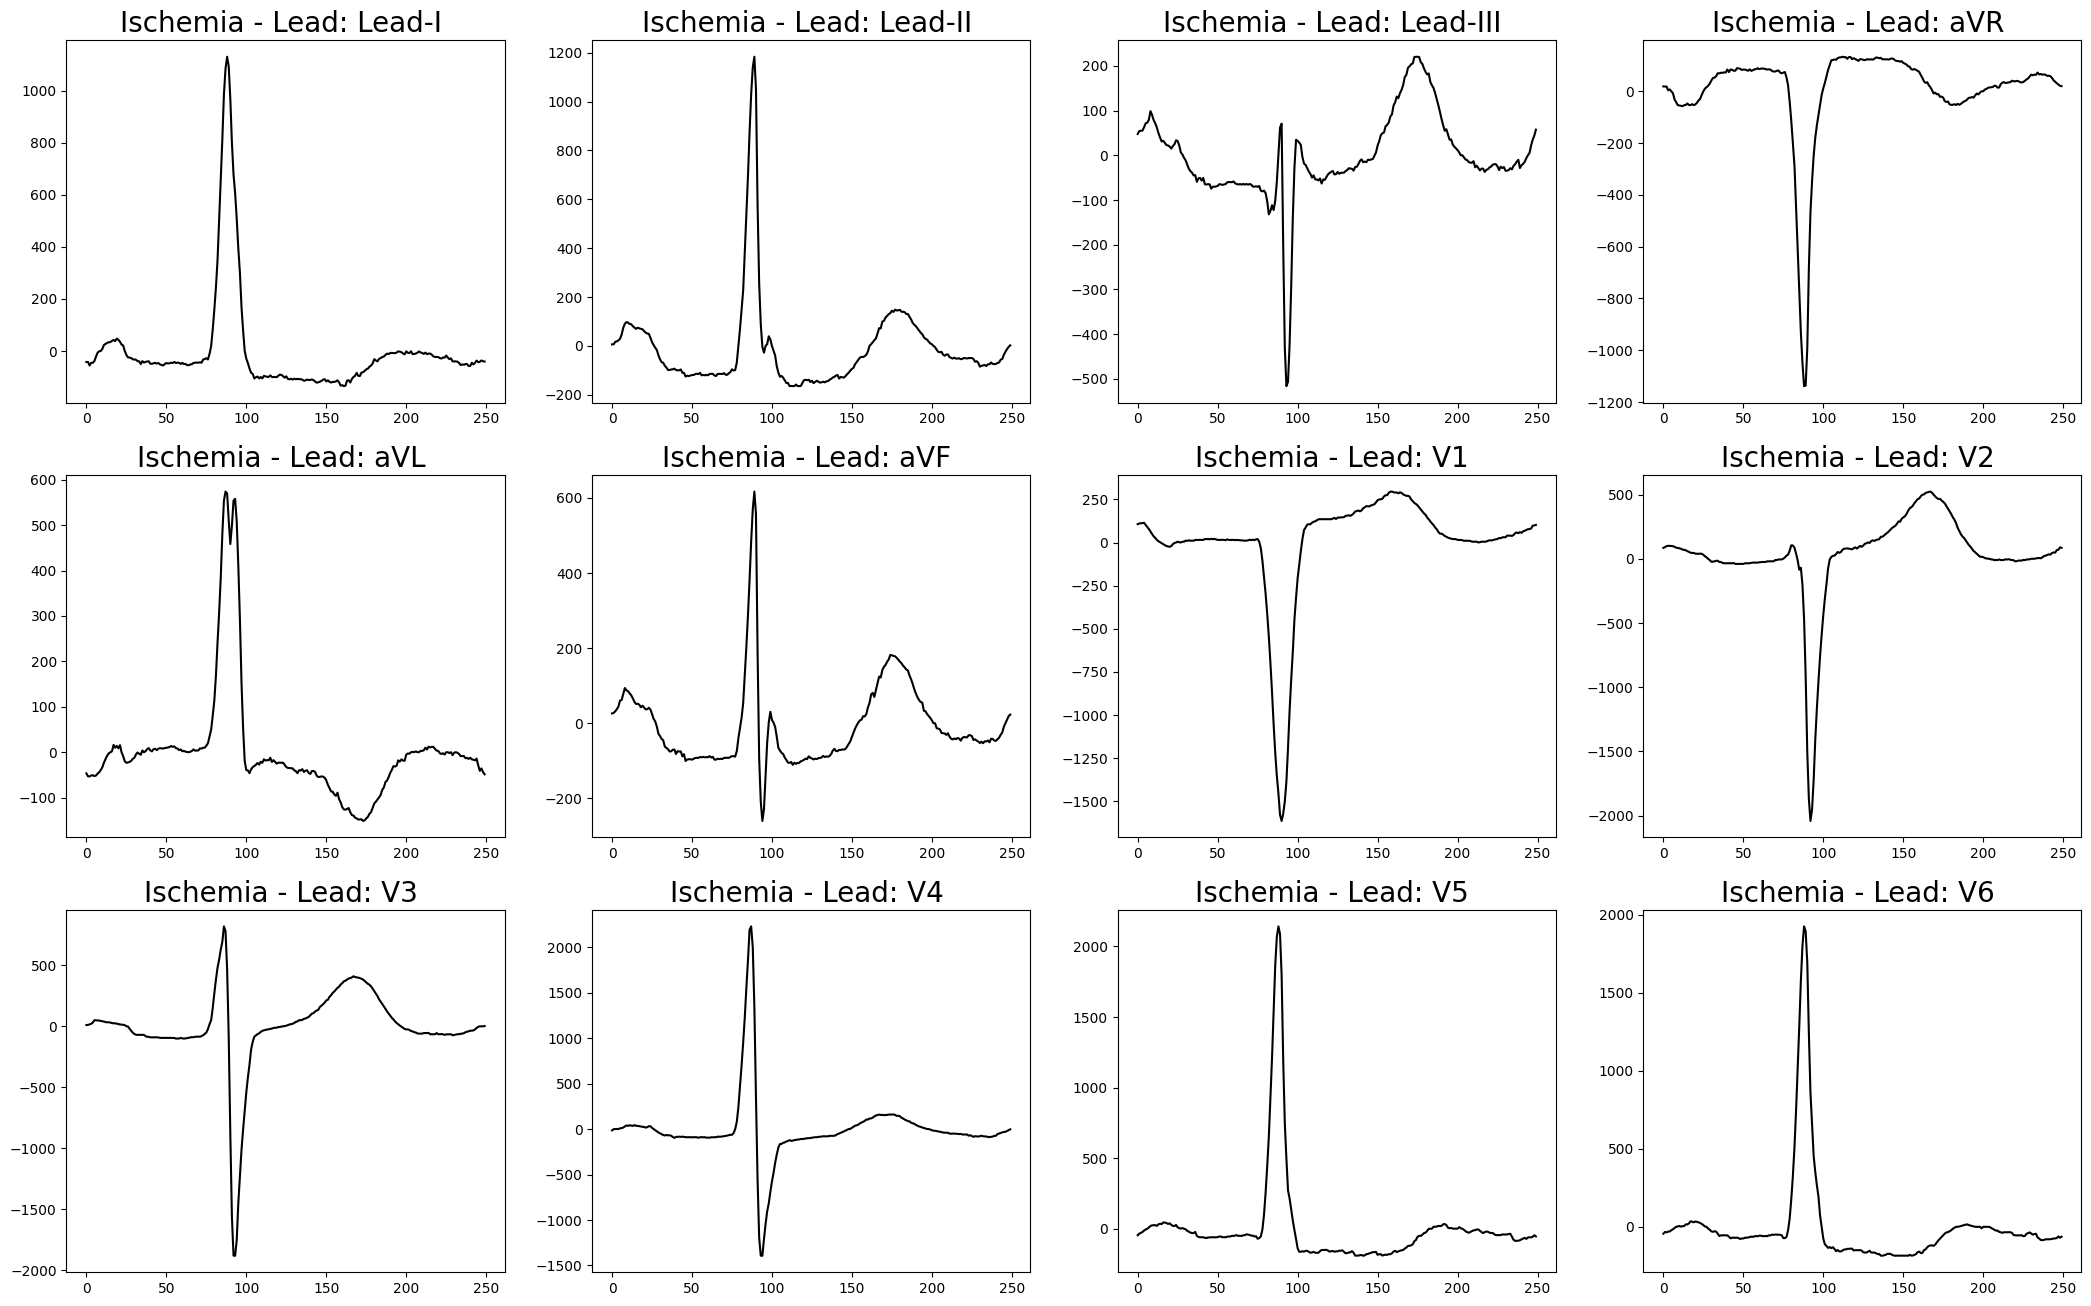

In [ ]:
# Visualizing ECG Leads: Ischemia Example
leads = ["Lead-I","Lead-II", "Lead-III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
plt.figure(figsize=(26, 16))
for l in range(12):
    plt.subplot(3, 4, l + 1)
    plt.title("Ischemia - Lead: {} ".format(leads[l]), fontsize=20)
    plt.plot(clean_ischemia[0].reshape(12,250)[l],'k')

In [ ]:
# Set up training parameters
val_acc = []
train_acc = []
true_pos = np.ones([10,100])
false_pos = np.ones([10,100])
batchsize=30
num_epochs = 5 # Set epochs

In [ ]:
# Define the FCN architecture
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv1d(12, 128, kernel_size=15, padding='same')
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=10, padding='same')
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=5, padding='same')
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.2)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256*250, 2)

    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)))
        conv1 = self.dropout1(conv1)
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        gap_layer = self.flatten(conv2)
        output_layer = self.fc(gap_layer)
        return output_layer

In [ ]:
# Implement the train_model function
def train_model(model, train_loader, val_loader, epochs=2, learning_rate=0.0001, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1, verbose=True, mode='max', min_lr=1e-6)
    # Checkpoint for real subset
    early_stopping = EarlyStopping(patience=15, verbose=True, path='checkpoint_real_subset_model.pth')

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_correct_predictions = 0
        total_train_samples = 0
        for batch_idx, (data, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [TRAIN]")):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            train_correct_predictions += (predicted_labels == labels).sum().item()
            total_train_samples += labels.size(0)

        avg_train_loss = train_loss_epoch / len(train_loader)
        train_accuracy = train_correct_predictions / total_train_samples

        model.eval()
        val_loss_epoch = 0.0
        val_correct_predictions = 0
        total_val_samples = 0
        all_val_labels = []
        all_val_probs = []

        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(val_loader, ):
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss_epoch += loss.item()
                _, predicted_labels = torch.max(outputs, 1)
                val_correct_predictions += (predicted_labels == labels).sum().item()
                total_val_samples += labels.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        avg_val_loss = val_loss_epoch / len(val_loader)
        val_accuracy = val_correct_predictions / total_val_samples

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        scheduler.step(val_accuracy)
        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Load real subset checkpoint
    model.load_state_dict(torch.load('checkpoint_real_subset_model.pth'))

    roc_auc = roc_auc_score(all_val_labels, all_val_probs)
    print(f"Validation ROC AUC: {roc_auc:.4f}")

    return history, all_val_labels, all_val_probs



In [ ]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_accuracy, model):
        score = val_accuracy
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0
    def save_checkpoint(self, val_accuracy, model):
        if self.verbose:
            self.trace_func(f'Validation accuracy increased ({self.val_loss_min:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_accuracy

In [ ]:
# Define ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, ecg_data, labels):
        self.ecg_data = torch.tensor(ecg_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.ecg_data[idx], self.labels[idx]


In [ ]:
# Track training and validation metrics

num_norm = len(clean_norm)
num_ischemia = len(clean_ischemia)

# Splitting for validation and testing
n_val_norm = min(200, num_norm // 4)  # Reduced validation size for test split
n_val_ischemia = min(200, num_ischemia // 4)  # Reduced validation size for test split
n_test_norm = min(100, num_norm // 5)
n_test_ischemia = min(100, num_ischemia // 5)

# Indices for validation and testing
val_norm_index = np.random.choice(np.arange(num_norm), n_val_norm, replace=False)
val_ischemia_index = np.random.choice(np.arange(num_ischemia), n_val_ischemia, replace=False)
test_norm_index = np.random.choice(np.arange(num_norm), n_test_norm, replace=False)
test_ischemia_index = np.random.choice(np.arange(num_ischemia), n_test_ischemia, replace=False)

# Ensure no overlap between validation and test sets
test_norm_index = np.setdiff1d(test_norm_index, val_norm_index)
test_ischemia_index = np.setdiff1d(test_ischemia_index, val_ischemia_index)


# Data splitting for training, validation, and testing
norm_val = clean_norm[val_norm_index]
norm_test = clean_norm[test_norm_index]

# Removing validation and test indices from training data for Normal Sinus
train_norm_index = np.setdiff1d(np.arange(num_norm), np.concatenate([val_norm_index, test_norm_index]))
norm_train = clean_norm[train_norm_index]

ischemia_val = clean_ischemia[val_ischemia_index]
ischemia_test = clean_ischemia[test_ischemia_index]

# Removing validation and test indices from training data for Ischemia
train_ischemia_index = np.setdiff1d(np.arange(num_ischemia), np.concatenate([val_ischemia_index, test_ischemia_index]))
ischemia_train = clean_ischemia[train_ischemia_index]


# Creating labels for training, validation, and testing
y_norm_train = np.zeros(norm_train.shape[0])
y_norm_val = np.zeros(norm_val.shape[0])
y_norm_test = np.zeros(norm_test.shape[0])

y_ischemia_train = np.ones(ischemia_train.shape[0])
y_ischemia_val = np.ones(ischemia_val.shape[0])
y_ischemia_test = np.ones(ischemia_test.shape[0])

# Combining data and labels for training, validation, and testing
train_data_np = np.vstack([norm_train, ischemia_train])
y_train_np = np.hstack([y_norm_train, y_ischemia_train])

val_data_np = np.vstack([norm_val, ischemia_val])
y_val_np = np.hstack([y_norm_val, y_ischemia_val])

test_data_np = np.vstack([norm_test, ischemia_test])
y_test_np = np.hstack([y_norm_test, y_ischemia_test])

# Sample weights for training data
sample_weight = np.ones(shape=(len(y_train_np),))
sample_weight[y_train_np == 1] = len(norm_train) / len(ischemia_train)

# Creating datasets and data loaders
train_dataset = ECGDataset(train_data_np, y_train_np)
val_dataset = ECGDataset(val_data_np, y_val_np)
test_dataset = ECGDataset(test_data_np, y_test_np)  # Test dataset

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)  # Test data loader

dataset_len = num_norm + num_ischemia

In [ ]:
# Plot training and validation metrics
def plot_metrics(history):
    fig = go.Figure([
        go.Scatter(
            name='Accuracy Train',
            x=np.arange(1, len(history['train_acc']) + 1),
            y=history['train_acc'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='Accuracy Validation',
            x=np.arange(1, len(history['val_acc']) + 1),
            y=history['val_acc'],
            mode='lines',
            line=dict(color='rgb(255, 0, 0)'),
        )
    ])
    fig.update_layout(
        yaxis_title='Accuracy',
        xaxis_title='Epochs',
        title='Training and Validation Accuracy',
        hovermode="x"
    )
    fig.show()

    fig_loss = go.Figure([
        go.Scatter(
            name='Loss Train',
            x=np.arange(1, len(history['train_loss']) + 1),
            y=history['train_loss'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='Loss Validation',
            x=np.arange(1, len(history['val_loss']) + 1),
            y=history['val_loss'],
            mode='lines',
            line=dict(color='rgb(255, 0, 0)'),
        )
    ])
    fig_loss.update_layout(
        yaxis_title='Loss',
        xaxis_title='Epochs',
        title='Training and Validation Loss',
        hovermode="x"
    )
    fig_loss.show()

In [ ]:
# Generate and plot the ROC curve

def plot_roc_curve(val_labels, val_probs):
    fpr, tpr, _ = roc_curve(val_labels, val_probs)
    auc_score = roc_auc_score(val_labels, val_probs)

    fig_roc = go.Figure(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {auc_score:.2f})'))
    fig_roc.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        title='Receiver Operating Characteristic (ROC) Curve',
        showlegend=True
    )
    fig_roc.show()

In [ ]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN().to(device)

history, val_labels, val_probs = train_model(model, train_loader, val_loader, epochs=50, device=device) # Reduced epochs for quick test

plot_metrics(history)
plot_roc_curve(val_labels, val_probs)

# Evaluate on test set
if test_loader: # Check if test_loader is not empty
    model.eval()
    test_loss = 0.0
    test_correct_predictions = 0
    total_test_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            test_correct_predictions += (predicted_labels == labels).sum().item()
            total_test_samples += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct_predictions / total_test_samples
    print(f"Test Loss (Real Data Subset Test): {avg_test_loss:.4f}, Test Accuracy (Real Data Subset Test): {test_accuracy:.4f}") # Indicate real data subset test
else:
    print("No test data available to evaluate.") # Indicate no test data

# Saved real subset test model
torch.save(model.state_dict(), 'Ischemia_Classification.pth')

Epoch 1/50 [TRAIN]: 100%|██████████| 569/569 [03:49<00:00,  2.48it/s]


Validation accuracy increased (inf --> 0.937500).  Saving model ...
Epoch 1/50: Train Loss: 0.1100, Train Acc: 0.9651, Val Loss: 0.1413, Val Acc: 0.9375


Epoch 2/50 [TRAIN]: 100%|██████████| 569/569 [03:46<00:00,  2.51it/s]


EarlyStopping counter: 1 out of 15
Epoch 2/50: Train Loss: 0.0754, Train Acc: 0.9760, Val Loss: 0.1907, Val Acc: 0.9275


Epoch 3/50 [TRAIN]: 100%|██████████| 569/569 [03:49<00:00,  2.48it/s]


Validation accuracy increased (0.937500 --> 0.965000).  Saving model ...
Epoch 3/50: Train Loss: 0.0766, Train Acc: 0.9739, Val Loss: 0.1028, Val Acc: 0.9650


Epoch 4/50 [TRAIN]: 100%|██████████| 569/569 [03:55<00:00,  2.42it/s]


EarlyStopping counter: 1 out of 15
Epoch 4/50: Train Loss: 0.0722, Train Acc: 0.9765, Val Loss: 0.1206, Val Acc: 0.9600


Epoch 5/50 [TRAIN]: 100%|██████████| 569/569 [03:55<00:00,  2.42it/s]


EarlyStopping counter: 2 out of 15
Epoch 5/50: Train Loss: 0.0601, Train Acc: 0.9802, Val Loss: 0.1353, Val Acc: 0.9550


Epoch 6/50 [TRAIN]: 100%|██████████| 569/569 [03:55<00:00,  2.42it/s]


EarlyStopping counter: 3 out of 15
Epoch 6/50: Train Loss: 0.0407, Train Acc: 0.9862, Val Loss: 0.1116, Val Acc: 0.9600


Epoch 7/50 [TRAIN]: 100%|██████████| 569/569 [03:47<00:00,  2.50it/s]


EarlyStopping counter: 4 out of 15
Epoch 7/50: Train Loss: 0.0384, Train Acc: 0.9873, Val Loss: 0.1020, Val Acc: 0.9625


Epoch 8/50 [TRAIN]: 100%|██████████| 569/569 [03:48<00:00,  2.49it/s]


EarlyStopping counter: 5 out of 15
Epoch 8/50: Train Loss: 0.0342, Train Acc: 0.9885, Val Loss: 0.1175, Val Acc: 0.9525


Epoch 9/50 [TRAIN]: 100%|██████████| 569/569 [04:06<00:00,  2.31it/s]


EarlyStopping counter: 6 out of 15
Epoch 9/50: Train Loss: 0.0352, Train Acc: 0.9871, Val Loss: 0.1056, Val Acc: 0.9575


Epoch 10/50 [TRAIN]: 100%|██████████| 569/569 [03:53<00:00,  2.44it/s]


EarlyStopping counter: 7 out of 15
Epoch 10/50: Train Loss: 0.0350, Train Acc: 0.9882, Val Loss: 0.1049, Val Acc: 0.9600


Epoch 11/50 [TRAIN]: 100%|██████████| 569/569 [03:50<00:00,  2.47it/s]


EarlyStopping counter: 8 out of 15
Epoch 11/50: Train Loss: 0.0341, Train Acc: 0.9886, Val Loss: 0.1077, Val Acc: 0.9550


Epoch 12/50 [TRAIN]: 100%|██████████| 569/569 [03:48<00:00,  2.49it/s]


EarlyStopping counter: 9 out of 15
Epoch 12/50: Train Loss: 0.0341, Train Acc: 0.9880, Val Loss: 0.1118, Val Acc: 0.9550


Epoch 13/50 [TRAIN]: 100%|██████████| 569/569 [03:49<00:00,  2.48it/s]


EarlyStopping counter: 10 out of 15
Epoch 13/50: Train Loss: 0.0339, Train Acc: 0.9882, Val Loss: 0.1008, Val Acc: 0.9625


Epoch 14/50 [TRAIN]: 100%|██████████| 569/569 [03:49<00:00,  2.48it/s]


EarlyStopping counter: 11 out of 15
Epoch 14/50: Train Loss: 0.0349, Train Acc: 0.9880, Val Loss: 0.1192, Val Acc: 0.9525


Epoch 15/50 [TRAIN]: 100%|██████████| 569/569 [03:49<00:00,  2.48it/s]


EarlyStopping counter: 12 out of 15
Epoch 15/50: Train Loss: 0.0341, Train Acc: 0.9884, Val Loss: 0.1115, Val Acc: 0.9575


Epoch 16/50 [TRAIN]: 100%|██████████| 569/569 [03:48<00:00,  2.49it/s]


EarlyStopping counter: 13 out of 15
Epoch 16/50: Train Loss: 0.0335, Train Acc: 0.9890, Val Loss: 0.1102, Val Acc: 0.9525


Epoch 17/50 [TRAIN]: 100%|██████████| 569/569 [03:47<00:00,  2.50it/s]


EarlyStopping counter: 14 out of 15
Epoch 17/50: Train Loss: 0.0331, Train Acc: 0.9878, Val Loss: 0.1148, Val Acc: 0.9575


Epoch 18/50 [TRAIN]: 100%|██████████| 569/569 [03:48<00:00,  2.49it/s]


EarlyStopping counter: 15 out of 15
Early stopping triggered
Validation ROC AUC: 0.9942


<ipython-input-21-c16e46c3e30f>:68: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Loss (Real Data Subset Test): 0.2078, Test Accuracy (Real Data Subset Test): 0.9430


**Model Inference With Dummpy Input and Real ECG data**

In [ ]:
# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN().to(device)
model.load_state_dict(torch.load('wpw_model_pytorch_realsubset_test.pth', map_location=device, weights_only=True))
# Set the model to evaluation mode
model.eval()

# Create dummy input (batch_size, channels, sequence_length)
dummy_input = torch.randn(1, 12, 250).to(device)

# Pass dummy input through the model
with torch.no_grad():
    output = model(dummy_input)
    probabilities = F.softmax(output, dim=1)
    print(probabilities)

# Print the output
print("output",output)

tensor([[0.8767, 0.1233]])
output tensor([[ 0.9382, -1.0233]])


In [ ]:
# Load the real data sample (HR00102)
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

data_path = '/root/.cache/kagglehub/datasets/bjoernjostein/ischemia-dataset/versions/1/ischemia_dataset/'
data_file = os.path.join(data_path, 'HR00102.mat')
header_file = os.path.join(data_path, 'HR00102.hea')

data, header_data = load_challenge_data(data_file)
data = pad_sequences(data, maxlen=5000, truncating='post', padding="post")

# Call `process_ecgs` and `remove_nans` functions
processed_data = process_ecgs(data[np.newaxis, ...])
processed_data = remove_nans(processed_data)

real_data_sample = processed_data[0]


# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN().to(device)
model.load_state_dict(torch.load('Ischemia_Classification.pth', map_location=device, weights_only=True))
model.eval()

# Prepare the data for the model
real_data_tensor = torch.tensor(real_data_sample, dtype=torch.float32).unsqueeze(0).to(device)

# Classify the sample
with torch.no_grad():
    output = model(real_data_tensor)
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

# Print the results
print("Predicted Probabilities:", probabilities)
print("Predicted Class:", predicted_class.item())

100%|██████████| 1/1 [00:00<00:00, 5683.34it/s]

Predicted Probabilities: tensor([[1.3236e-08, 1.0000e+00]])
Predicted Class: 1


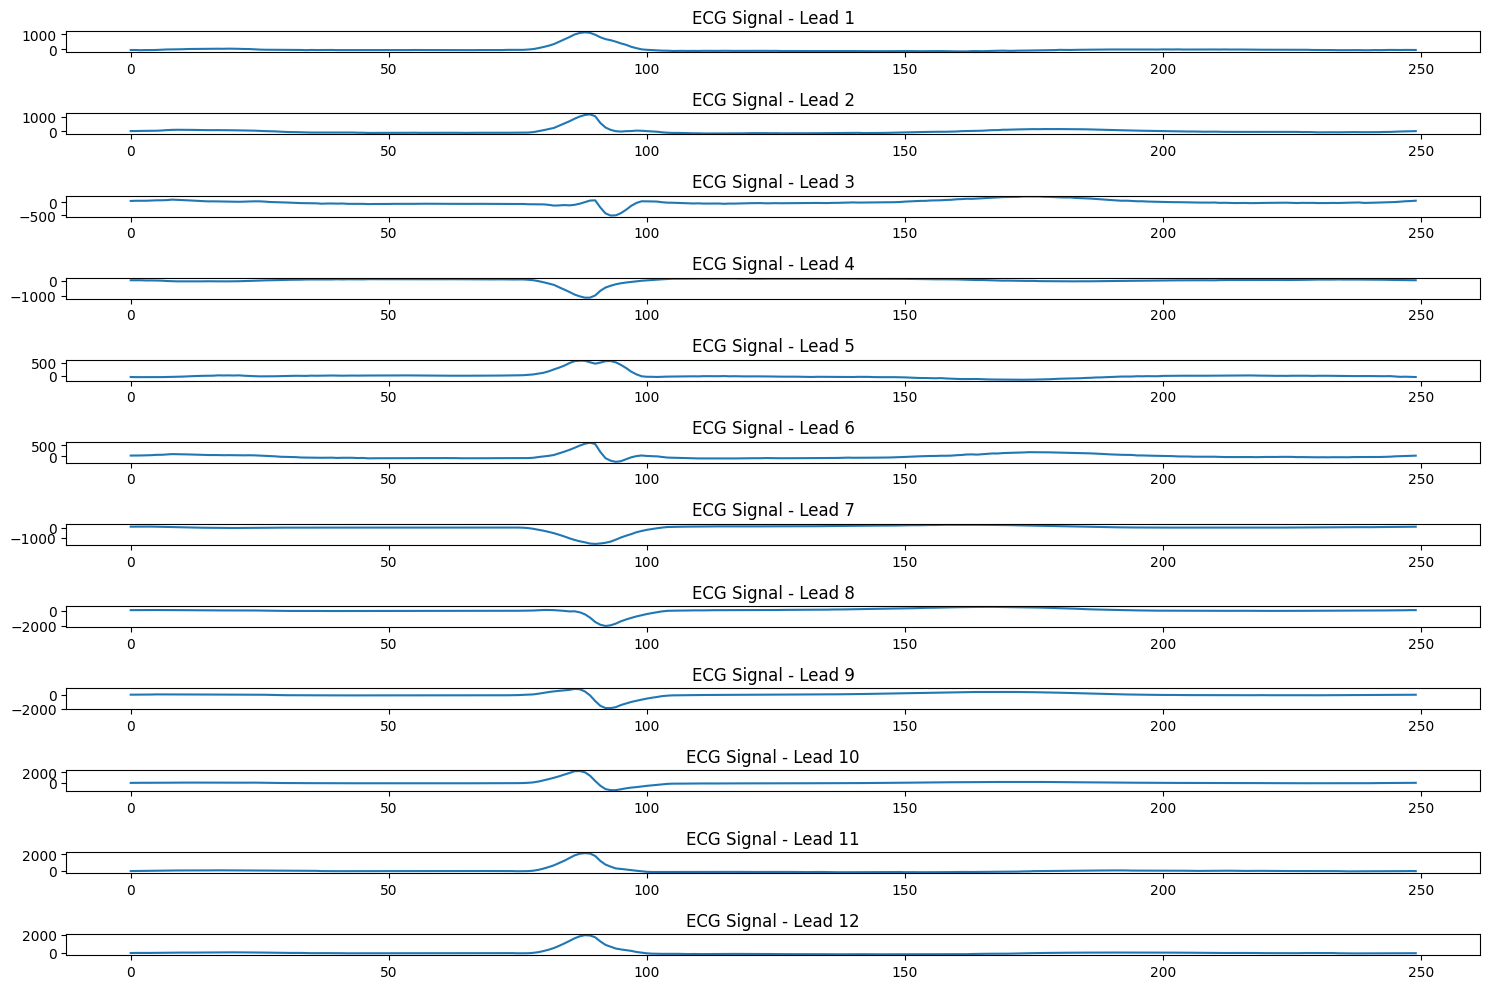

In [ ]:
# Get the number of leads
num_leads = real_data_sample.shape[0]

plt.figure(figsize=(15, 10))
for i in range(num_leads):
  # Create subplots for each lead
  plt.subplot(num_leads, 1, i + 1)
  plt.plot(real_data_sample[i])
  plt.title(f'ECG Signal - Lead {i+1}')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

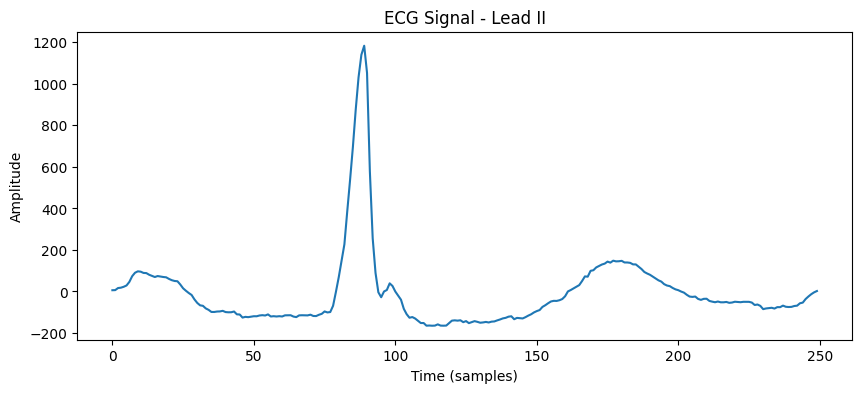

In [ ]:
# Extract data for Lead II
lead_data = real_data_sample[1]

# Plot the ECG signal for Lead II
plt.figure(figsize=(10, 4))
plt.plot(lead_data)
plt.title('ECG Signal - Lead II')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()